# Examples from paper

In this notebook we will use [shenfun](https://github.com/spectralDNS/shenfun) to solve the example problems from the paper

    M Mortensen, "A generic and strictly banded spectral Petrov-Galerkin method for differential equations with polynomial coefficients"

For the solution we will use generic orthogonal polynomials $Q_n(x)$ defined as 

\begin{equation}
Q_n(x) = g_n^{(\alpha,\beta)} P^{(\alpha,\beta)}_n(x),
\end{equation}

where $P^{(\alpha,\beta)}_n$ is the regular $n$'th [Jacobi polynomial](https://en.wikipedia.org/wiki/Jacobi_polynomials) with parameters $\alpha, \beta$ both $ >-1$. 

For ultraspherical polynomials we write

\begin{equation}
Q^{(\alpha)}_n(x) = g_n^{(\alpha, \alpha)} P^{(\alpha,\alpha)}_n(x), \label{eq:ultra}
\end{equation}

when the scaling function $g_n^{(\alpha,\alpha)} = 1/P^{(\alpha,\alpha)}_n(1)$. This covers Chebyshev polynomials of first kind $T_n$ and Legendre polynomials $L_n$

\begin{align}
T_n(x) &= Q^{(-1/2)}_n, \\
L_n(x) &= Q^{(0)}_n,
\end{align}

but not Chebyshev polynomials of second kind $U_n$. For $U_n$ the scaling function is $g_n^{(1/2,1/2)}=(n+1)/P^{(1/2,1/2)}_n(1)$ such that

\begin{equation}
U_n(x) = (n+1)Q^{(1/2)}_n
\end{equation}

In what follows we use $Q_n$ to represent either one of $T_n, L_n, U_n$ or $Q^{(\alpha)}_n$. However, in the paper we restrict the attention in the worked examples to the ultraspherical polynomials with scaling as in Eq. \eqref{eq:ultra}. This is done because the different scaling requires different stencil matrices for the trial functions.

For any family of orthogonal polynomials we will make use of a test function $\phi^{(k)}_n$ defined for integer $k$ as

$$
\phi^{(k)}_n = \frac{(1-x^2)^k}{h^{(k)}_{n+k}} \frac{d^k Q_{n+k}}{dx^k},
$$

where

$$
h^{(k)}_{n+k} = \int_{-1}^1 \left(\frac{d^k Q_{n+k}}{dx^k}\right)^k \omega^{\alpha+k} dx,
$$

and the weight $\omega^{\alpha}=(1-x^2)^{\alpha}$.


# Section-4.3.1

We consider the first order problem

\begin{equation}
    u'(x)+\frac{1}{ax^2+1}u(x)=s(x), \quad u(-1) = b, \quad x \in [-1, 1], \label{eq:firstproblem}
\end{equation}

For this first order problem we use the trial space $\text{S}_N=\text{span}\{\psi_n\}_{n=0}^{N-1}$ with basis function $\psi_n=Q^{(\alpha)}_n+Q^{(\alpha)}_{n+1}$, corresponding to a stencil matrix $K=(\delta_{mn}+\delta_{m+1,n})_{m=0,n=0}^{N-1, N} \in \mathbb{R}^{N\times N+1}$. Next, we multiply through with $ax^2+1$ to get only polynomial coefficients, and attempt to find $u\in \text{S}^{(1)}_N$ such that

\begin{equation}
    ((ax^2+1) u', v)_{\omega} + (u, v)_{\omega} = (f, v)_{\omega}, \quad \forall v \in \text{V}^{(1)}_{N+1} = \text{span}\{\phi^{(1)}_n\}_{n=0}^{N-1},
\end{equation}

where $f(x) = (ax^2+1) s(x)$. 

Note that for Chebyshev polynomials of the second kind (that are not used in the paper) the trial functions will be slightly different due to boundary conditions: $\psi_n=U_n-\frac{n+1}{n+3}U_{n+2}$.

If $b\ne 0$, then an additional basis function is used for the trial space

\begin{equation}
\psi_{N} = Q^{(\alpha)}_0 = 1.
\end{equation}

This additional basis function will not affect the coefficient matrix of the system.


We start by importing functionality from shenfun and [sympy](www.sympy.org)

In [1]:
import sympy as sp
from shenfun import *
config['assembly']['splitmeasure'] = True

Define the manufactured solution $u(x)=\exp(-0.25x^4)(x+1)$, which satisfies $u(-1)=0$.

In [2]:
x = sp.Symbol('x', real=True)
ue = sp.exp(-x**4/4)*(x+1)

<div class="alert alert-block alert-info">
Note that any function will do, but this one has a homogeneous boundary condition for `x=0`. If the solution does not have a homogeneous boundary condition, then the SN space below will add a basis function like (3) since `ue.subs(x, -1)` in the `SN` functionspace will evaluate to a nonzero number
    
    SN = FunctionSpace(N, family, bc=(ue.subs(x, -1), None))
</div>


Below we create a function `main` that will solve the problem using three differen techniques. Using `method=1` corresponds to a pure Petrov-Galerkin method, computing integrals with high precision. For `method=2` we restrict the right hand side function to the space $\text{P}_{N+1}$, whereas in `method=3` we restrict to $\text{P}_{N}$. 

In [3]:
def main(N, method=1, family='C', alpha=0.5, a=1, ue=None, returnmat=False, returnu=False):
    """Methods for solving Eq. (5)
    
    Parameters
    ----------
    N : integer
        The number of quadrature points
    method : number in (1, 2, 3), optional
        The choice of method
        - 1 pure Petrov Galerkin
        - 2 Numerical - restrict f to $P_{N+1}$
        - 3 Numerical - restrict f to $P_{N}$
    family : str, optional
        - Chebyshev
        - Legendre
        - Ultraspherical
        - ChebyshevU
    alpha : number > -1, optional
        Parameter used only if family is Ultrasperical
    a : number, optional
        Parameter in Eq. (1)
    ue : Sympy expression, optional
        Exact solution
    returnmat : boolean, optional
        Whether to simply return the coefficient matrix without computing the error
    returnu : boolean, optional
        Whether to return the expansion coefficients without computing the error
    """
    SN = FunctionSpace(N, family, bc=(ue.subs(x, -1), None), alpha=alpha)
    VN = FunctionSpace(N+1, family, basis='Phi1', alpha=alpha)
    u = TrialFunction(SN)
    v = TestFunction(VN)
    D = inner((a*x**2+1)*grad(u), v)
    M = inner(u, v)
    D += M if isinstance(M, list) else [M]
    if returnmat:
        return np.sum(np.array(D, dtype=object))

    sol = la.Solver(D)
    u_hat = Function(SN)
    X = SN.mesh()
    ul = sp.lambdify(x, ue)
    uq = Array(SN, buffer=np.array([ul(j) for j in X]))
    fe = (a*x**2+1)*sp.diff(ue, x, 1) + ue
    
    if method == 1:
        M = 400 # Just some high number. Much smaller will do
        VM = FunctionSpace(M, family, basis='Phi1')
        fM = Function(VM)
        fM = VM.scalar_product(Array(VM, buffer=fe), fM)
        f_hat = Function(VN)
        f_hat[:N-1] = fM[:N-1]
        u_hat = sol(f_hat, u_hat)
    elif method == 2:
        T = VN.get_orthogonal()
        fN = Array(T, buffer=fe)
        f_hat = inner(v, fN)
        u_hat = sol(f_hat, u_hat)
    elif method == 3: # quasi
        T = SN.get_orthogonal()
        fN = Function(T, buffer=fe).refine(N+1)
        f_hat = inner(v, fN)
        u_hat = sol(f_hat, u_hat)

    if returnu:
        return u_hat
    
    uj = u_hat.backward()
    error = np.sqrt(inner(1, (uj-uq)**2))
    return error

Finally, solve problem for a range of different quadrature points and plot the $L^2$ error. Below we use Chebyshev, but any ultraspherical polynomial will do. Just switch the family from 'C' below to either one of 'L', 'Q' or 'U'.

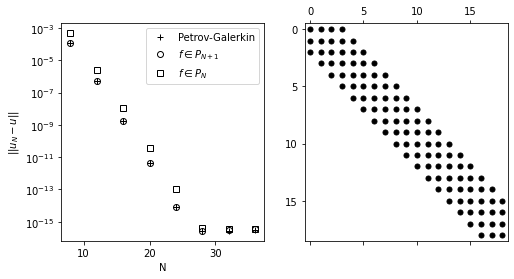

In [4]:
import matplotlib.pyplot as plt
cols = ('k',)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for c, fam in zip(cols, 'C'):
    error = {}
    M = np.arange(8, 40, 4)
    for method in (1, 2, 3):
        error[method] = []
        for N in M:
            error[method].append(main(N, method, fam, ue=ue))
    ax[0].semilogy(M, error[1], '+', M, error[2], 'o', M, error[3], 's', fillstyle='none', color=c)
ax[0].legend(['Petrov-Galerkin', '$f \in {P}_{N+1}$', '$f \in {P}_{N}$'])
ax[0].set(xlabel='N', ylabel='$||u_N-u||$')
ax[1].spy(main(20, 2, 'C', ue=ue, returnmat=True).diags(), markersize=5, mec='k', mfc='k', marker='o', aspect='auto')
plt.show()


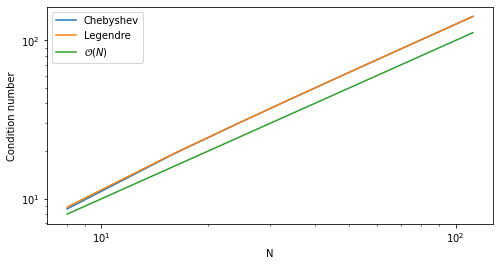

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
cond = {}
for fam in 'CL':
    cond[fam] = []
    M = np.arange(8, 120, 8)
    for N in M:
        cond[fam].append(np.linalg.cond(main(N, 2, fam, ue=ue, returnmat=True).diags().toarray()))
    ax.loglog(M, cond[fam])

ax.loglog(M, M)
ax.legend(['Chebyshev', 'Legendre', r'$\mathcal{O}(N)$'])
ax.set(xlabel='N', ylabel='Condition number')
plt.show()


Now use the manufactured solution from 

    Olver, Sheehan and Townsend, Alex, "A Fast and Well-Conditioned Spectral Method", SIAM Review, 55, 3, (2013), 10.1137/120865458
   
$$
u(x) = \exp(-\frac{1}{\sqrt{a}}\left(\tan^{-1} (\sqrt{a} x) - \tan^{-1} (\sqrt{a}) \right))
$$

where $a=5\cdot 10^4$ is the parameter in Eq. (1). The boundary condition is $u(-1)=1$.

[Text(0.5, 0, 'N'), Text(0, 0.5, '$||u_N-u||$')]

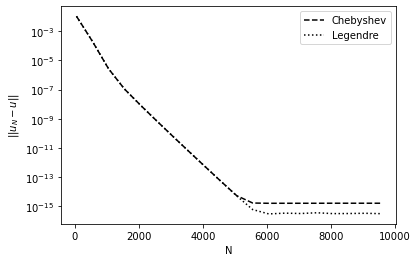

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
error = {}
ue = sp.exp(-(sp.atan(sp.sqrt(50000)*x) + sp.atan(sp.sqrt(50000)))/sp.sqrt(50000))
M = np.arange(50, 10000, 500)
for fam in 'CL':
    error[fam] = []
    for N in M:
        error[fam].append(main(N, 2, fam, a=50000, ue=ue))
ax.semilogy(M, error[fam], 'k--', M, error['C'], 'k:', fillstyle='none')
ax.legend(['Chebyshev', 'Legendre'])
ax.set(xlabel='N', ylabel='$||u_N-u||$')